In [ ]:
%pip install --quiet -U pip -r ../requirements/requirements-train.txt ../.

In [1]:
%matplotlib widget

In [2]:
import pickle

import jax
from hydra import compose, initialize

from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device

/home/r-boige/workspace/jumanji/jumanji/training/loggers.py:28: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


## Load configs

In [3]:
with initialize(version_base=None, config_path="../jumanji/training/configs"):
    cfg = compose(config_name="config.yaml", overrides=["env=sudoku", "agent=a2c"])
cfg

{'agent': 'a2c', 'seed': 0, 'logger': {'type': 'terminal', 'save_checkpoint': False, 'name': '${agent}_${env.name}'}, 'env': {'name': 'sudoku', 'registered_version': 'Sudoku-very-easy-v0', 'network': {'key_size': 32, 'num_heads': 4, 'policy_layers': [128], 'value_layers': [128]}, 'training': {'num_epochs': 300, 'num_learner_steps_per_epoch': 1000, 'n_steps': 40, 'total_batch_size': 128}, 'evaluation': {'eval_total_batch_size': 1000, 'greedy_eval_total_batch_size': 1000}, 'a2c': {'normalize_advantage': False, 'discount_factor': 1.0, 'bootstrapping_factor': 0.95, 'l_pg': 1.0, 'l_td': 1.0, 'l_en': 0.01, 'learning_rate': 0.0001}}}

## Load a saved checkpoint

In [4]:
with open("JUJU-781","rb") as f:
    training_state = pickle.load(f)

params = first_from_device(training_state.params_state.params)
env = setup_env(cfg).unwrapped
agent = setup_agent(cfg, env)
policy = jax.jit(agent.make_policy(params.actor, stochastic = False))

## Rollout a few episodes

In [10]:
NUM_EPISODES = 10

states = []
key = jax.random.PRNGKey(0)
for episode in range(NUM_EPISODES):
    key, reset_key = jax.random.split(key) 
    state, timestep = jax.jit(env.reset)(reset_key)
    while not timestep.last():
        key, action_key = jax.random.split(key)
        observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
        action, _ = policy(observation, action_key)
        state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0))
        states.append(state)
    print(timestep.reward)
        
    # Freeze the terminal frame to pause the GIF.
    for _ in range(10):
        states.append(state)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## Save GIF

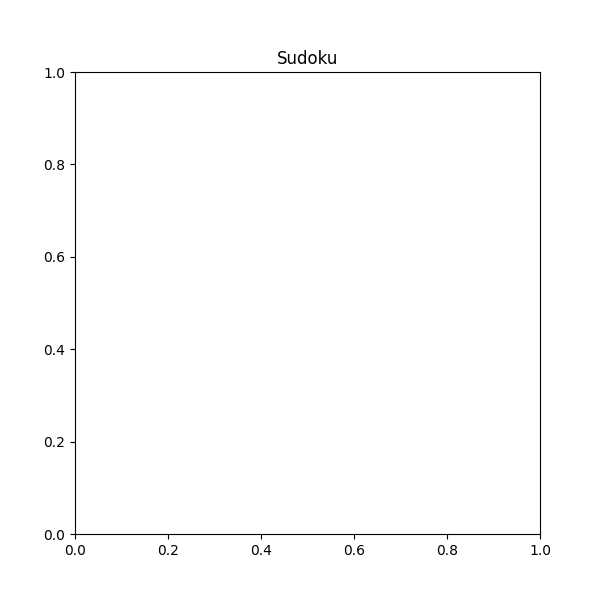

In [11]:
env.animate(states, interval=150)

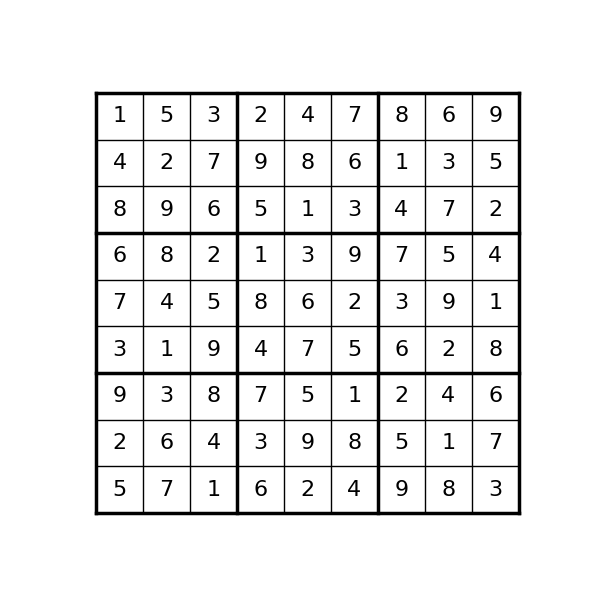

In [12]:
env.animate(states, interval=150).save("./sudoku.gif")

## Save PNG

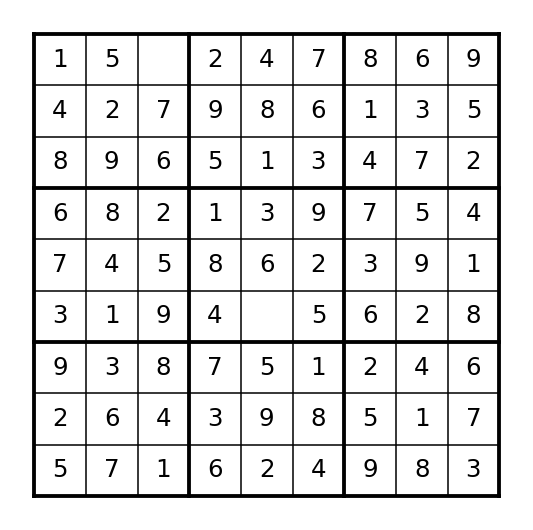

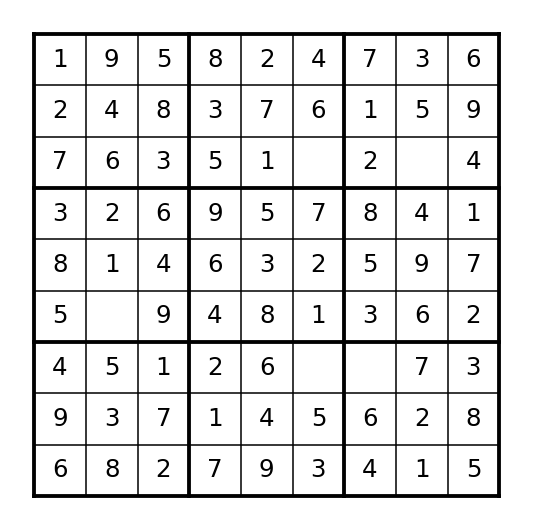

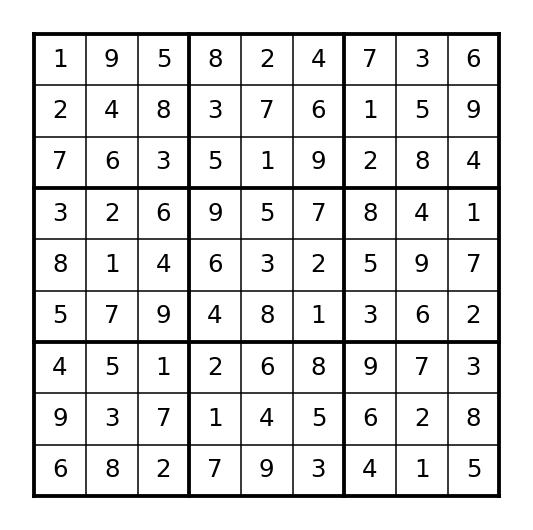

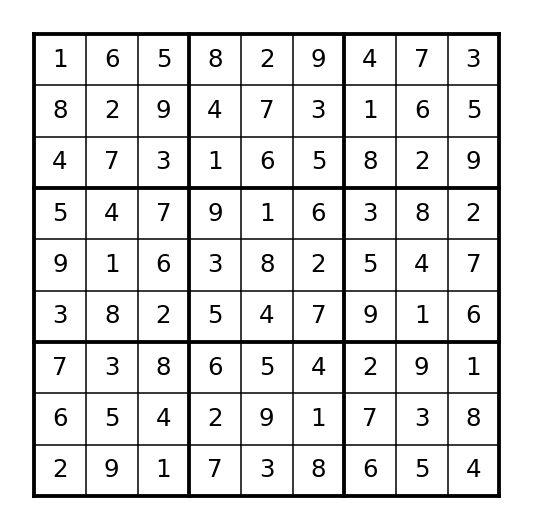

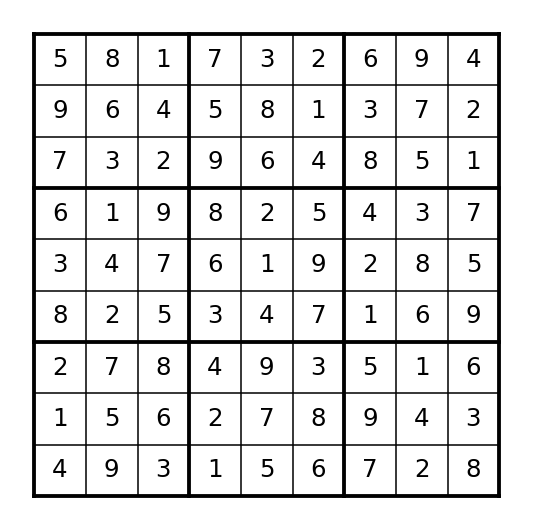

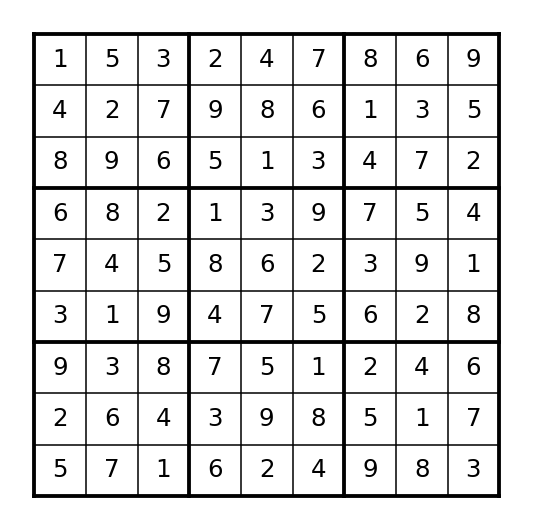

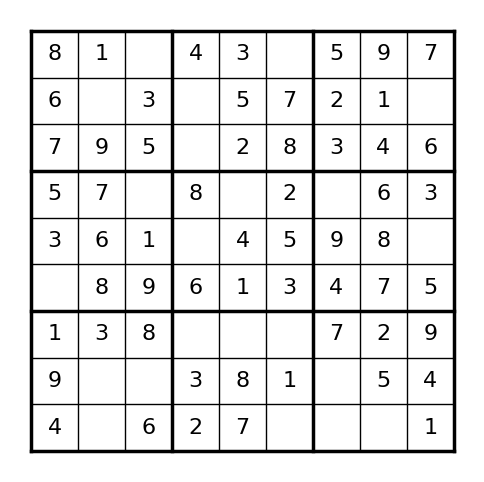

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
env.render(states[117])
plt.savefig("sudoku.png", dpi=300)